In [122]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs, xesmf, time, pandas as pd, matplotlib as mpl
from utils import *
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
from datetime import datetime
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
import statsmodels.formula.api as sm
%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
client.close()

In [11]:
cluster = LocalCluster(n_workers=8, memory_limit='32GB') #16 is best (matches number of cores)
client = Client(cluster)

In [44]:
#tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))
#SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

# Temperature

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorofyll

### Observations

In [2]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc')) # Monthly satellite observation of Chlorophyll

In [3]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

### NorESM2-LM

In [3]:
# NOT NEEDED ANYMORE! ALL DAILY CHLOS READ TO FILE FOR BARENTS (april-september) Takes 15 mins to read all in if not
# start = time.time()
# chlos = get_bucket_data('chlos', time_res='daily', thing='Oday', experiment='historical')
# chlos1 = clip_to_region(chlos.chlos.isel(time=slice(0, 365*50)), minlat=65, minlon=0, maxlon=70)
# chlos2 = clip_to_region(chlos.chlos.isel(time=slice(365*50, 2 * 365*50)), minlat=65, minlon=0, maxlon=70)
# chlos3 = clip_to_region(chlos.chlos.isel(time=slice(2*365*50, -1)), minlat=65, minlon=0, maxlon=70)
# chlos_full = xr.concat([chlos1, chlos2, chlos3], dim='time')
# print(time.time() - start)

hey!
None
Request: s3://escience2022/Ada/daily/chlos_Oday_NorESM2-LM_historical_*.nc
901.5332541465759


In [4]:
chlos_noresm = xr.load_dataset('chlos_NorESM2-LM_full_try2')

In [5]:
SI_noresm = xr.load_dataarray('SI_NorESM2-LM_monthly')

In [6]:
chlos_barents = clip_to_region(chlos_noresm.chlos, minlat=75, maxlat=80, minlon=20, maxlon=60)
SI_barents = clip_to_region(SI_noresm, minlat=75, maxlat=80, minlon=20, maxlon=60)

In [51]:
#chlos_barents.sel(time='18590501')

In [146]:
slider_map(chlos_barents, freq='D', start=datetime(2013, 4, 1), stop=datetime(2014, 10, 1), name='NorESM2-LM', model=True, minlat=74)

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-04-01'…

In [147]:
slider_map(SI_barents, freq='M', start=datetime(2013, 1, 1), stop=datetime(2014, 12, 1), minlat=74, 
           name='NorESM2-LM', model=True, color='Blues', levels=np.linspace(0, 100, 21))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-01', T…

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/jovyan/escience-2022/Tjaernoe2022-group6/notebooks/Stian/utils.py:129: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


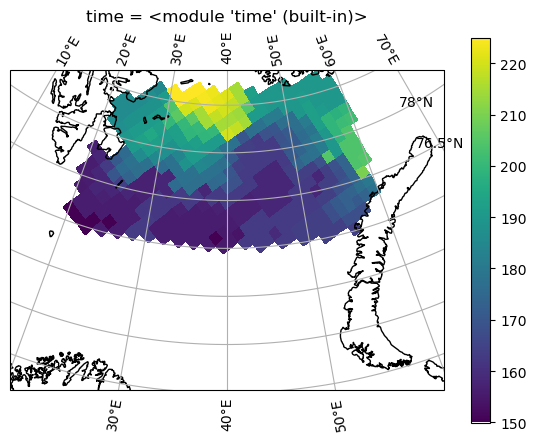

In [172]:
peaks_eachcell = find_peak_dates(chlos_barents)
peaks_eachcell = xr.DataArray(df['dayofyear'].values.reshape(shape), dims=['year', 'j', 'i'], 
                  coords=dict(longitude=(["j", "i"], chlos_barents.longitude.values), 
                              latitude=(["j", "i"], chlos_barents.latitude.values), 
                              time=time))
peaks_eachcell.isel(year=-1).plot(ax=barentsMap()[1], x='longitude', y='latitude', transform=ccrs.PlateCarree())

In [169]:
_dat = chlos_barents.copy()
_dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()
_dat = _dat.groupby('time.year')
peak_dates_each_cell = [_dat[year].idxmax(dim='time').values for year in _dat.groups.keys()]
shape = np.shape(peak_dates_each_cell)

df = xr.DataArray(peak_dates_each_cell).to_dataframe('date')

df['dayofyear'] = pd.to_datetime(df['date']).dt.dayofyear
df['year'] = pd.to_datetime(df['date']).dt.year
#plt.plot(df['year'], df['dayofyear'])
da = xr.DataArray(df['dayofyear'].values.reshape(shape), dims=['years', 'j', 'i'], 
                  coords=dict(longitude=(["j", "i"], chlos_barents.longitude.values), 
                              latitude=(["j", "i"], chlos_barents.latitude.values), 
                              time=time))#np.arange(1850, 1850+165)))

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_929/1611716850.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


In [20]:
chlos_barents_mean = regional_average(chlos_barents)
SI_barents_mean = regional_average(SI_barents)
peak_dates = find_peak_dates(chlos_barents_mean)

Found local areacello NetCDF
Found local areacello NetCDF


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/jovyan/escience-2022/Tjaernoe2022-group6/notebooks/Stian/utils.py:129: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


In [21]:
chlos_anomaly = time_anomaly(chlos_barents, 0, 365*30, -365*30, -1)
SI_anomaly = time_anomaly(SI_barents, 0, 365*30, -365*30, -1)

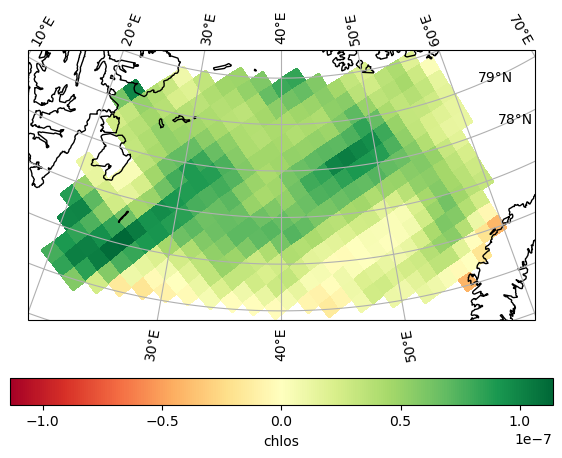

In [26]:
chlos_anomaly.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                   cmap='RdYlGn', cbar_kwargs={'location': 'bottom'})

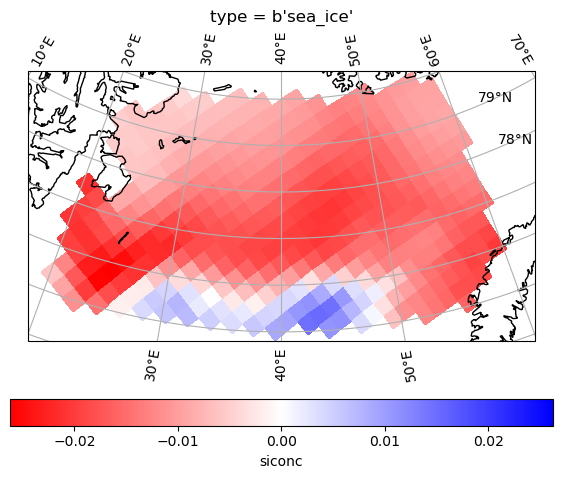

In [28]:
SI_anomaly.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                        cmap='bwr_r', cbar_kwargs={'location': 'bottom'})

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f65bf720610>>


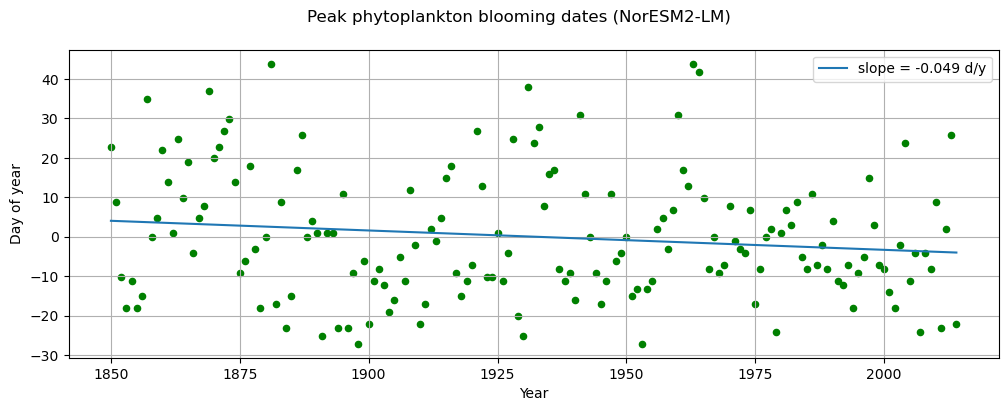

In [26]:
scatter_dates(peak_dates, last_n_years=0)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158ba053a0>>


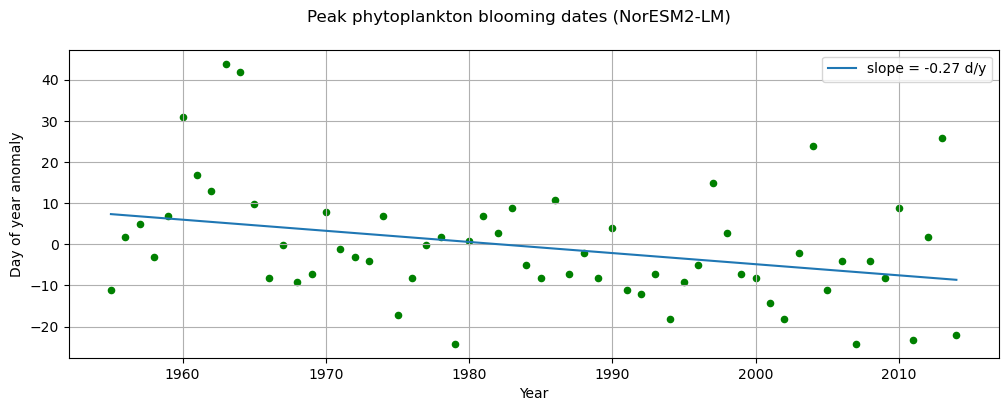

In [111]:
scatter_dates(peak_dates, last_n_years=60)

In [97]:
SI_yearly_mean = SI_barents_mean.groupby('time.year').mean(dim='time')

df = pd.DataFrame([SI_yearly_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158d723d00>>


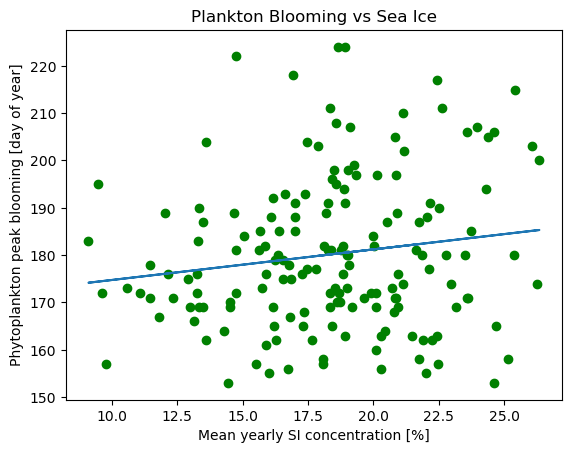

In [109]:
plt.xlabel('Mean yearly SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_yearly_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_yearly_mean.values, a * SI_yearly_mean.values + b)

In [96]:
SI_june_mean = SI_barents_mean.groupby('time.month')[5]
df = pd.DataFrame([SI_june_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158be8f580>>


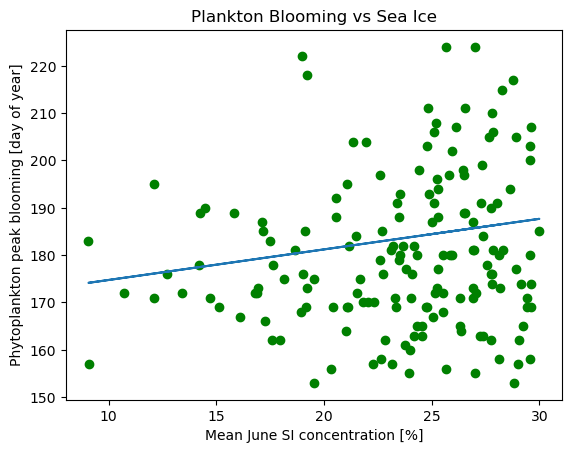

In [108]:
plt.xlabel('Mean June SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_june_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_june_mean.values, a * SI_march_mean.values + b)

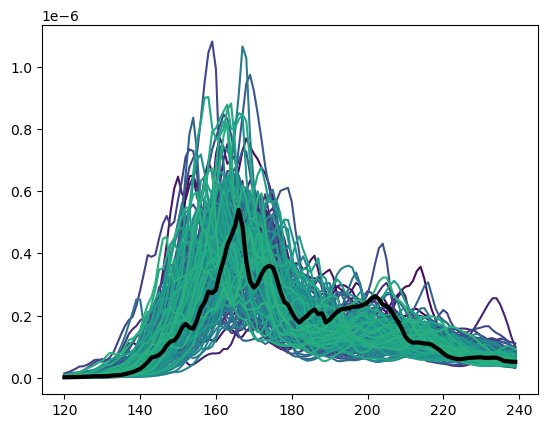

In [89]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::int(cmap.N/165)]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(1850, 2015)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

chlos_daily_mean_grouped = chlos_daily_mean.chlos.groupby('time.year')
[ax.plot(np.arange(120, 120+30*4), chlos_daily_mean_grouped[year].isel(time=slice(120, 120+30*4)), color=cmaplist[year-1850]) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), chlos_daily_mean.chlos.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


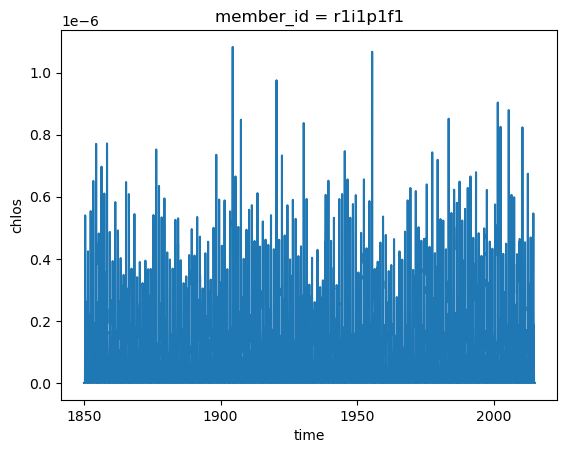

In [18]:
chlos_daily_mean.chlos.plot()

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer

- Get daily observations

- Repeat for CESM

- Repeat for NorESM-SSP385